In [ ]:
'''Python 3.13에서는 아직 TensorFlow가 공식 지원 안됨. Python 3.11 이하 (특히 3.9, 3.10, 3.11) 사용 권고

# 여러 버전의 Python을 설치하고 관리해야 한다면, pyenv 또는 anaconda 등으로 여러 버전의 Python 설치 후 프로젝트별 버전 전환 관리할 수 있음
# 또는 직접 수동으로 각각 Python 버전 설치도 가능하나 각 실행 파일 디렉토리 위치 경로를 수작업으로 관리 필요

# 파이썬 버전 제어 및 범용 개발이 중심이라면 → 🧑‍💻 pyenv + venv/poetry 조합 추천
# 데이터 과학/머신러닝 중심이라면 → 🎯 Anaconda (또는 Miniconda) 권장
# 빠른 개발 및 배포 → 📦 forge는 최근 등장한 관리 도구로 Jupyter 환경 설정 별도 필요, 아직 패키지 배포 자동화 및 GPU 지원 미비

# Python 버전 낮추기 또는 여러 버전 이용 (예시) : 

# 🧑‍💻 pyenv 설치 후, pyenv install 3.10.13
# pyenv global 3.10.13   # 또는 pyenv local 3.10.13 (현재 폴더만)
# pip install numpy matplotlib pandas scikit-learn tensorflow

# 🎯 anaconda (https://www.anaconda.com/products/distribution) 설치 후 
# conda create -n tf python=3.10.13
# conda activate tf
# pip install numpy matplotlib pandas scikit-learn tensorflow

# 🧪 모두 다 설치했다면 → 하나의 목적에만 집중해 사용하는 것이 충돌 방지에 좋음'''

# Installing the packeges
# graphviz는 먼저 OS 패키지 설치 필요 (apt-get install graphviz 또는 brew install graphviz)
!python -m pip install numpy matplotlib pandas scikit-learn pydot graphviz
!python -m pip install -U 'tensorflow==2.20.*' 'keras>=3.11,<4'
!python -m pip install ipykernel -U --force-reinstall # ipykernel 패키지를 설치 (Jupyter 커널용)

In [1]:
# 1. 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Input, LSTM, Dropout, Dense

plt.style.use('fivethirtyeight')

In [ ]:
# 2. 헬퍼 함수 정의

def plot_predictions_with_anomalies(test_data, predicted_data, anomalies):
    """
    실제 값, 예측 값, 그리고 탐지된 이상치를 함께 시각화합니다.
    """
    plt.figure(figsize=(16, 6))
    plt.plot(test_data, color='blue', label='Actual Transaction Amount')
    plt.plot(predicted_data, color='green', label='Predicted Transaction Amount', linestyle='--')
    
    # 이상치 지점을 빨간색 점으로 표시
    anomaly_indices = np.where(anomalies)[0]
    plt.scatter(anomaly_indices, test_data[anomaly_indices], color='red', label='Detected Anomaly', s=100)
    
    plt.title('Credit Card Anomaly Detection')
    plt.xlabel('Time (Transaction Index)')
    plt.ylabel('Transaction Amount')
    plt.legend()
    # ### TODO: 결과 그래프를 저장할 경로를 지정하세요.
    # plt.savefig(r'path/to/your/anomaly_detection_result.png')
    plt.show()

def calculate_rmse(test, predicted):
    """
    모델의 전반적인 예측 성능을 RMSE로 평가합니다.
    """
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print(f"The root mean squared error is {rmse:.4f}.")
    return rmse

def detect_anomalies(test_data, predicted_data, sigma=3):
    """
    예측 오류를 기반으로 이상치를 탐지합니다. (예: 평균 + 3 * 표준편차 이상)
    """
    errors = np.abs(test_data - predicted_data)
    # 임계값 설정 (평균 오차 + N * 표준편차)
    threshold = np.mean(errors) + sigma * np.std(errors)
    anomalies = errors > threshold
    
    print(f"Anomaly Threshold (based on {sigma} sigma): {threshold:.4f}")
    print(f"Detected anomalies: {np.sum(anomalies)} out of {len(anomalies)} transactions.")
    
    return anomalies, threshold

In [ ]:
# Connectiing Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# 3. 데이터 로딩 및 전처리

# ### TODO: 신용카드 데이터셋 CSV 파일 경로를 입력하세요.
file_path = r'C:\Users\SKAX\Desktop\workspace\2025_MLOPS\service_model\model_serving\server\uploaded_files\your_credit_card_data.csv'
# dataset = pd.read_csv(file_path, index_col='Date', parse_dates=['Date']) # 시계열 인덱스가 있다면 사용
dataset = pd.read_csv(file_path) # 일반 인덱스일 경우

# ### TODO: 모델 학습에 사용할 특성(feature)들을 선택하세요.
# 예: ['Amount', 'Time', 'V1', 'V2', ...]
features_to_use = ['Feature1', 'Feature2', 'Amount'] 
# ### TODO: 예측할 대상이 되는 특성(feature)을 지정하세요. (보통 'Amount')
feature_to_predict = 'Amount'

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


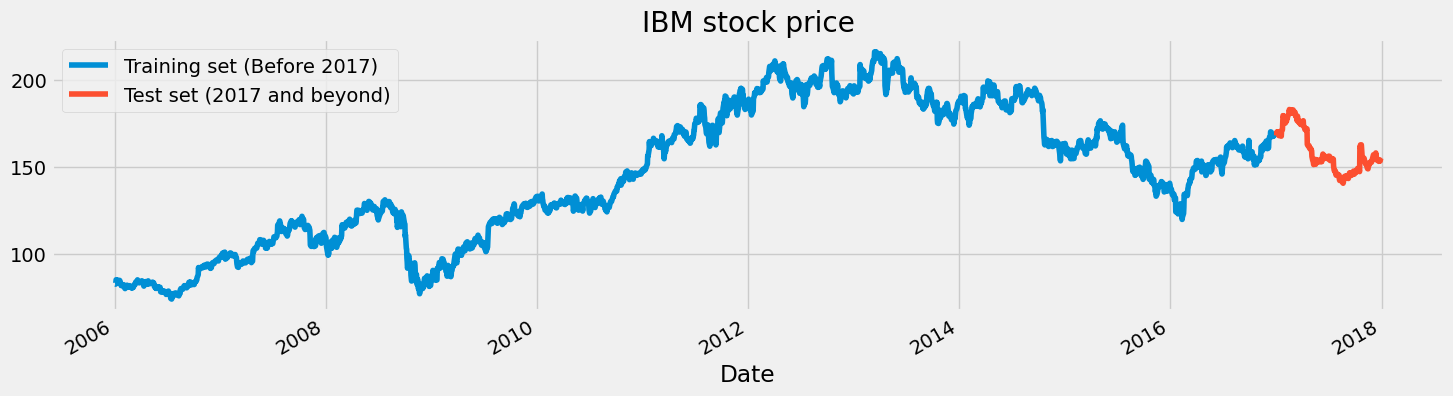

In [ ]:
# 데이터셋 분리 (예시: 80% 훈련, 20% 테스트)
train_size = int(len(dataset) * 0.8)
training_set_df = dataset.iloc[:train_size][features_to_use]
test_set_df = dataset.iloc[train_size:][features_to_use]

print(f"Training set shape: {training_set_df.shape}")
print(f"Test set shape: {test_set_df.shape}")

In [ ]:
# 스케일링
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set_df)

# 시계열 데이터 구조 생성 (X: 과거 60개 데이터, y: 다음 1개 데이터)
timesteps = 60
X_train = []
y_train = []

# 예측 대상 컬럼의 인덱스 찾기
target_col_index = features_to_use.index(feature_to_predict)

for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timesteps:i, :]) # 모든 특성을 X로 사용
    y_train.append(training_set_scaled[i, target_col_index]) # 예측 대상 특성만 y로 사용

X_train, y_train = np.array(X_train), np.array(y_train)

# LSTM 입력에 맞게 3D 형태로 재구성: (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features_to_use)))

# 4. LSTM 모델 정의 및 학습

def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) # 출력은 1개 (예: 다음 시점의 거래 금액)
    
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    return model

# 모델 빌드 및 학습
regressor = build_model((X_train.shape[1], X_train.shape[2]))
regressor.summary()
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

# ### TODO: 학습된 모델을 저장할 경로를 지정하세요.
# regressor.save(r'path/to/your/credit_card_anomaly_model.keras')

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - loss: 0.0224
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - loss: 0.0096
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - loss: 0.0082
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0068
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0060
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0055
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0049
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0043
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0046
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0040
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0037
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0037
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0035
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.0033
Epoch 15/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


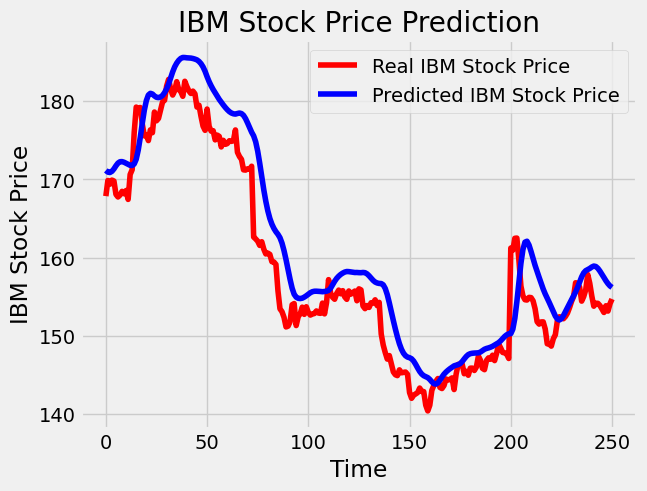

In [ ]:
# 5. 테스트 데이터 준비 및 예측

# 테스트셋 준비 시, 훈련셋의 마지막 `timesteps` 만큼의 데이터가 필요함
total_inputs = pd.concat((training_set_df, test_set_df), axis=0)
inputs = total_inputs[len(total_inputs) - len(test_set_df) - timesteps:].values
inputs = sc.transform(inputs)

X_test = []
for i in range(timesteps, len(inputs)):
    X_test.append(inputs[i-timesteps:i, :])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features_to_use)))
# 예측 수행
predicted_scaled = regressor.predict(X_test)

# 예측 결과를 원래 스케일로 되돌리기 위한 트릭
# 스케일러는 [feature1, feature2, amount] 순서로 학습되었으므로,
# amount 예측값을 되돌리려면 더미 데이터프레임을 만들어야 함
dummy_df = np.zeros((len(predicted_scaled), len(features_to_use)))
dummy_df[:, target_col_index] = predicted_scaled.flatten()
predicted_values = sc.inverse_transform(dummy_df)[:, target_col_index]

# 실제 값 (테스트셋)
actual_values = test_set_df[feature_to_predict].values

In [ ]:
# 6. 이상탐지 및 결과 시각화

# 모델 성능 평가 (RMSE)
calculate_rmse(actual_values, predicted_values)

# 이상치 탐지
anomalies, threshold = detect_anomalies(actual_values, predicted_values, sigma=3)

# 결과 시각화
plot_predictions_with_anomalies(actual_values, predicted_values, anomalies)

The root mean squared error is 4.379780247688356.


In [16]:
import sys
print(sys.version)

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
